In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%set_env CUDA_VISIBLE_DEVICES 4

env: CUDA_VISIBLE_DEVICES=4


In [93]:
from os import environ

import torch
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

from hydra import initialize, compose
from hydra.utils import instantiate

from bliss.catalog import TileCatalog, convert_mag_to_nmgy

In [3]:
# set up plots and colors
sns.set_theme("paper")
matplotlib.rc('text', usetex=True)
plt.rc("font", family="serif")

COLORS = [
    "#0072BD",  # blue
    "#D95319",  # orange
    "#EDB120",  # yellow
    "#7E2F8E",  # purple
    "#77AC30",  # green
	"#4DBEEE",  # light blue
    "#A2142F",  # dark red
]

# Load config, data, models

In [5]:
environ["BLISS_HOME"] = "~/bliss"
with initialize(config_path=".", version_base=None):
    cfg = compose("config")

In [6]:
# evaluate on fields not trained on
test_path = "/data/scratch/aakash/multi_field_test"
test_dataset = instantiate(cfg.cached_simulator, cached_data_path=test_path, splits="0:0/0:0/0:100")
print(len(test_dataset.test_dataloader().dataset))
trainer = instantiate(cfg.train.trainer, logger=None)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


32768


In [7]:
models = {
    "base": {
        "path": "../../output/NEW_PSF_MODELS/single_field/checkpoints/best_encoder.ckpt",
        "encoder_config": {
            "image_normalizer": {"use_deconv_channel": False, "concat_psf_params": False},
            "vd_spec": {"_target_": "bliss.encoder.new_variational_dist.NewVariationalDistSpec"}
        }
    },
    "unaware": {
        "path": "../../output/NEW_PSF_MODELS/multi_field_unaware/checkpoints/best_encoder.ckpt",
        "encoder_config": {
            "image_normalizer": {"use_deconv_channel": False, "concat_psf_params": False},
            "vd_spec": {"_target_": "bliss.encoder.new_variational_dist.NewVariationalDistSpec"}
        }
    },
    "encode_params": {
        "path": "../../output/NEW_PSF_MODELS/multi_field_encode_params/checkpoints/best_encoder.ckpt",
        "encoder_config": {
            "image_normalizer": {"use_deconv_channel": False, "concat_psf_params": True},
            "vd_spec": {"_target_": "bliss.encoder.new_variational_dist.NewVariationalDistSpec"}
        }
    }
    # "overfit_1": {
    #     "path": "../../output/OVERFIT/version_3_limit_galsim_factors/checkpoints/best_encoder.ckpt",
    #     "encoder_config": {
    #         "image_normalizer": {"use_deconv_channel": False, "concat_psf_params": True},
    #         "vd_spec": {"_target_": "bliss.encoder.variational_dist.VariationalDistSpec"}
    #     }
    # },
}

rep_key = list(models.keys())[0]

for model_name in models:
    encoder = instantiate(cfg.encoder, **models[model_name]["encoder_config"])
    encoder.load_state_dict(torch.load(models[model_name]["path"])["state_dict"])
    encoder.eval();
    models[model_name]["encoder"] = encoder

# Plot param bins

In [122]:
batch = next(iter(test_dataset.test_dataloader()))
tile_cat = TileCatalog(4, batch["tile_catalog"])
mags = tile_cat.magnitudes[..., 2]
mags = torch.masked_select(mags, tile_cat.is_on_mask * (mags < 22))
print(len(mags))

674


### Plot magnitudes

In [126]:
qs = torch.linspace(0, 1, 6)
print_qs = "  ".join([f"{q:<02.3f}" for q in qs])
print(f"{'Quantiles':<12s}{print_qs}\n------------")

mag_quantiles = torch.quantile(mags, qs)
print_qt = "  ".join([f"{qt:<2.3f}" for qt in mag_quantiles])
print(f"{'mags':<12s}{print_qt}")

Quantiles   0.000  0.200  0.400  0.600  0.800  1.000
------------
mags        15.037  18.723  20.012  20.899  21.450  21.999


<BarContainer object of 5 artists>

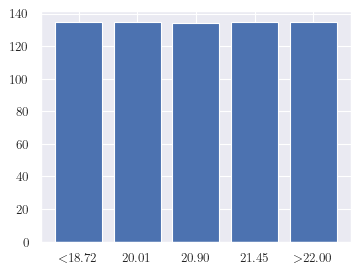

In [132]:
bins = mag_quantiles
bin_labels = [ f"{bins[i+1]:.2f}" for i in range(1, len(bins)-2)]
bin_labels.insert(0, f"$<${bins[1]:.2f}")
bin_labels.append(f"$>${bins[-1]:.2f}")

binvals, bin_edges = np.histogram(mags.numpy(), bins=bins)

fig, ax = plt.subplots(figsize=(4,3))
ax.bar(bin_labels, binvals)

### Plot galaxy params and find even quantiles

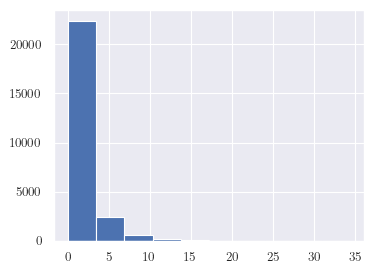

In [39]:
gp = ["disk_frac", "beta_radians", "disk_q", "a_d", "bulge_q", "a_b", "disk_hlr", "bulge_hlr"]

fig, ax = plt.subplots(figsize=(4, 3))
ax.hist(tile_cat["galaxy_params"][..., gp.index("disk_hlr")].flatten());

In [40]:
qs = torch.linspace(0, 1, 7)
print_qs = "  ".join([f"{q:<2.4f}" for q in qs])
print(f"{'Quantiles':<20s}{print_qs}\n------------")

for param_name in gp:
    vals = tile_cat["galaxy_params"][..., gp.index(param_name)]
    vals = vals.unsqueeze(-1).masked_select(tile_cat.galaxy_bools)
    quantiles = torch.quantile(vals, qs)
    print_qt = "  ".join([f"{qt:<2.4f}" for qt in quantiles])
    print(f"{param_name:<20s}{print_qt}")

Quantiles           0.0000  0.1667  0.3333  0.5000  0.6667  0.8333  1.0000
------------
disk_frac           0.0007  0.1514  0.3343  0.5141  0.6739  0.8392  0.9973
beta_radians        0.0012  0.5046  1.0516  1.5421  2.0816  2.6147  3.1397
disk_q              0.0044  0.1764  0.3253  0.4914  0.6588  0.8245  0.9987
a_d                 0.8372  0.8658  1.0222  1.4374  2.3332  4.1416  21.0171
bulge_q             0.0002  0.1536  0.3465  0.5064  0.6630  0.8323  0.9993
a_b                 0.4186  0.4335  0.5172  0.7212  1.0987  2.0239  10.2682
disk_hlr            0.0724  0.5201  0.7288  0.9464  1.4795  2.8159  20.2883
bulge_hlr           0.0314  0.2582  0.3687  0.4796  0.7098  1.3225  9.8621


# Evaluate models

In [11]:
models[rep_key]["encoder"].metrics

MetricCollection(
  (DetectionPerformance): DetectionPerformance()
  (SourceTypeAccuracy): SourceTypeAccuracy()
  (FluxError): FluxError()
  (GalaxyShapeError): GalaxyShapeError()
)

In [14]:
for model_name in models:
    print(f"Evaluating {model_name} model...")
    results = trainer.test(models[model_name]["encoder"], datamodule=test_dataset, verbose=False)
    models[model_name]["results"] = results

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4]


Evaluating base model...


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4]


Evaluating unaware model...


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4]


Evaluating encode_params model...


Testing: 0it [00:00, ?it/s]

### Compute bootstrap variance

In [15]:
data_for_var = {
    model: { key: [] for key in models[rep_key]["results"][0].keys() }
    for model in models
}

In [16]:
N_samples = 5
bootstrap_size = 64
max_len = len(test_dataset.data) - bootstrap_size

orig_test_slice = test_dataset.slices[2]
for i in tqdm(range(N_samples), desc=f"Bootstrapping {N_samples} samples"):
    random_batch = np.random.randint(0, max_len)
    test_dataset.slices[2] = slice(random_batch, random_batch + bootstrap_size)

    for model_name in models:
        results = trainer.test(models[model_name]["encoder"], dataloaders=test_dataset, verbose=False)

        for key, val in results[0].items():
            data_for_var[model_name][key].append(val)

test_dataset.slices[2] = orig_test_slice

Bootstrapping 5 samples:   0%|          | 0/5 [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4]


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4]


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4]


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4]


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4]


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4]


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4]


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4]


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4]


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4]


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4]


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4]


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4]


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4]


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4]


Testing: 0it [00:00, ?it/s]

In [17]:
stds = {
    model: {
        f"{key}_std": np.nanstd(val) for key, val in data_for_var[model].items()
    } for model in data_for_var
}

/home/aakashdp/.cache/pypoetry/virtualenvs/bliss-deblender-av05Bskt-py3.10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


### Concatenate results into dataframe

In [18]:
# Results
keys = list(models[rep_key]["results"][0].keys())
keys.extend(stds[rep_key].keys())

data = {}
for model_name in models:
    results = models[model_name]["results"][0] | stds[model_name]
    model_vals = [results[key] for key in keys]
    data[model_name] = model_vals

data_flat = pd.DataFrame.from_dict(data, orient="index", columns=[key.split("/")[1] for key in keys]).reset_index()
data_flat = data_flat.rename(columns={"index": "model"})
data_flat = data_flat.set_index("model")

with open("multi_field_limited_params.pt", "wb") as f:
    torch.save(data_flat.to_dict(), f)

from IPython.display import HTML
HTML(data_flat.to_html())

,_loss,precision,recall,f1,binned_precision_0,binned_precision_1,binned_precision_2,binned_precision_3,binned_precision_4,binned_precision_5,binned_precision_6,binned_precision_7,binned_recall_0,binned_recall_1,binned_recall_2,binned_recall_3,binned_recall_4,binned_recall_5,binned_recall_6,binned_recall_7,binned_f1_0,binned_f1_1,binned_f1_2,binned_f1_3,binned_f1_4,binned_f1_5,binned_f1_6,binned_f1_7,class_acc,binned_class_acc_0,binned_class_acc_1,binned_class_acc_2,binned_class_acc_3,binned_class_acc_4,binned_class_acc_5,binned_class_acc_6,binned_class_acc_7,r_flux_mape,binned_r_flux_mape_0,binned_r_flux_mape_1,binned_r_flux_mape_2,binned_r_flux_mape_3,binned_r_flux_mape_4,binned_r_flux_mape_5,binned_r_flux_mape_6,binned_r_flux_mape_7,disk_frac_mape,disk_frac_mape_mag_0,binned_disk_frac_mape_mag_0_0,binned_disk_frac_mape_mag_0_1,binned_disk_frac_mape_mag_0_2,binned_disk_frac_mape_mag_0_3,binned_disk_frac_mape_mag_0_4,binned_disk_frac_mape_mag_0_5,disk_frac_mape_mag_1,binned_disk_frac_mape_mag_1_0,binned_disk_frac_mape_mag_1_1,binned_disk_frac_mape_mag_1_2,binned_disk_frac_mape_mag_1_3,binned_disk_frac_mape_mag_1_4,binned_disk_frac_mape_mag_1_5,disk_frac_mape_mag_2,binned_disk_frac_mape_mag_2_0,binned_disk_frac_mape_mag_2_1,binned_disk_frac_mape_mag_2_2,binned_disk_frac_mape_mag_2_3,binned_disk_frac_mape_mag_2_4,binned_disk_frac_mape_mag_2_5,beta_radians_mape,beta_radians_mape_mag_0,binned_beta_radians_mape_mag_0_0,binned_beta_radians_mape_mag_0_1,binned_beta_radians_mape_mag_0_2,binned_beta_radians_mape_mag_0_3,binned_beta_radians_mape_mag_0_4,binned_beta_radians_mape_mag_0_5,beta_radians_mape_mag_1,binned_beta_radians_mape_mag_1_0,binned_beta_radians_mape_mag_1_1,binned_beta_radians_mape_mag_1_2,binned_beta_radians_mape_mag_1_3,binned_beta_radians_mape_mag_1_4,binned_beta_radians_mape_mag_1_5,beta_radians_mape_mag_2,binned_beta_radians_mape_mag_2_0,binned_beta_radians_mape_mag_2_1,binned_beta_radians_mape_mag_2_2,binned_beta_radians_mape_mag_2_3,binned_beta_radians_mape_mag_2_4,binned_beta_radians_mape_mag_2_5,disk_q_mape,disk_q_mape_mag_0,binned_disk_q_mape_mag_0_0,binned_disk_q_mape_mag_0_1,binned_disk_q_mape_mag_0_2,binned_disk_q_mape_mag_0_3,binned_disk_q_mape_mag_0_4,binned_disk_q_mape_mag_0_5,disk_q_mape_mag_1,binned_disk_q_mape_mag_1_0,binned_disk_q_mape_mag_1_1,binned_disk_q_mape_mag_1_2,binned_disk_q_mape_mag_1_3,binned_disk_q_mape_mag_1_4,binned_disk_q_mape_mag_1_5,disk_q_mape_mag_2,binned_disk_q_mape_mag_2_0,binned_disk_q_mape_mag_2_1,binned_disk_q_mape_mag_2_2,binned_disk_q_mape_mag_2_3,binned_disk_q_mape_mag_2_4,binned_disk_q_mape_mag_2_5,a_d_mape,a_d_mape_mag_0,binned_a_d_mape_mag_0_0,binned_a_d_mape_mag_0_1,binned_a_d_mape_mag_0_2,binned_a_d_mape_mag_0_3,binned_a_d_mape_mag_0_4,binned_a_d_mape_mag_0_5,a_d_mape_mag_1,binned_a_d_mape_mag_1_0,binned_a_d_mape_mag_1_1,binned_a_d_mape_mag_1_2,binned_a_d_mape_mag_1_3,binned_a_d_mape_mag_1_4,binned_a_d_mape_mag_1_5,a_d_mape_mag_2,binned_a_d_mape_mag_2_0,binned_a_d_mape_mag_2_1,binned_a_d_mape_mag_2_2,binned_a_d_mape_mag_2_3,binned_a_d_mape_mag_2_4,binned_a_d_mape_mag_2_5,bulge_q_mape,bulge_q_mape_mag_0,binned_bulge_q_mape_mag_0_0,binned_bulge_q_mape_mag_0_1,binned_bulge_q_mape_mag_0_2,binned_bulge_q_mape_mag_0_3,binned_bulge_q_mape_mag_0_4,binned_bulge_q_mape_mag_0_5,bulge_q_mape_mag_1,binned_bulge_q_mape_mag_1_0,binned_bulge_q_mape_mag_1_1,binned_bulge_q_mape_mag_1_2,binned_bulge_q_mape_mag_1_3,binned_bulge_q_mape_mag_1_4,binned_bulge_q_mape_mag_1_5,bulge_q_mape_mag_2,binned_bulge_q_mape_mag_2_0,binned_bulge_q_mape_mag_2_1,binned_bulge_q_mape_mag_2_2,binned_bulge_q_mape_mag_2_3,binned_bulge_q_mape_mag_2_4,binned_bulge_q_mape_mag_2_5,a_b_mape,a_b_mape_mag_0,binned_a_b_mape_mag_0_0,binned_a_b_mape_mag_0_1,binned_a_b_mape_mag_0_2,binned_a_b_mape_mag_0_3,binned_a_b_mape_mag_0_4,binned_a_b_mape_mag_0_5,a_b_mape_mag_1,binned_a_b_mape_mag_1_0,binned_a_b_mape_mag_1_1,binned_a_b_mape_mag_1_2,binned_a_b_mape_mag_1_3,binned_a_b_mape_mag_1_4,binned_a_b_mape_mag_1_5,a_b_mape_mag_2

# Plot results

### Plot Singly-binned results

Load saved results

In [32]:
data = torch.load("single_field_all.pt")

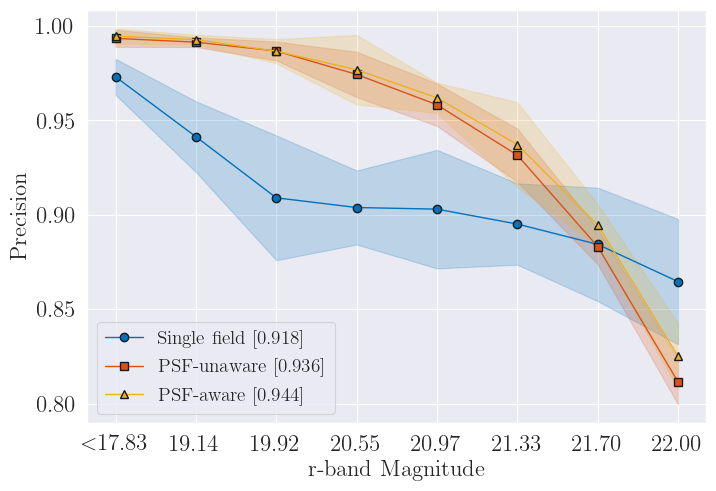

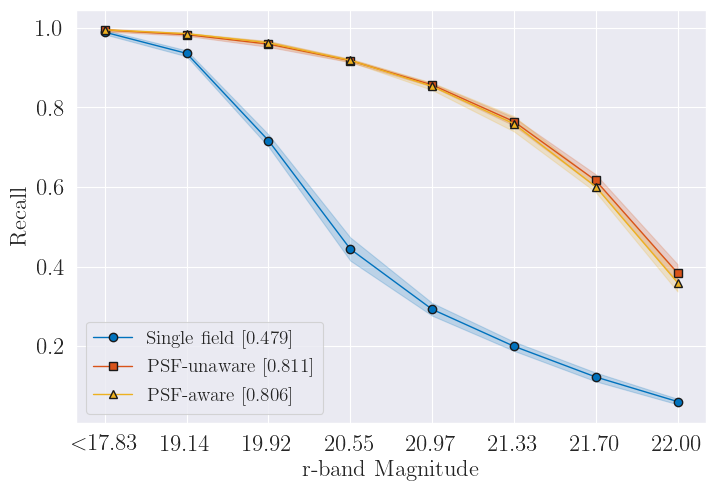

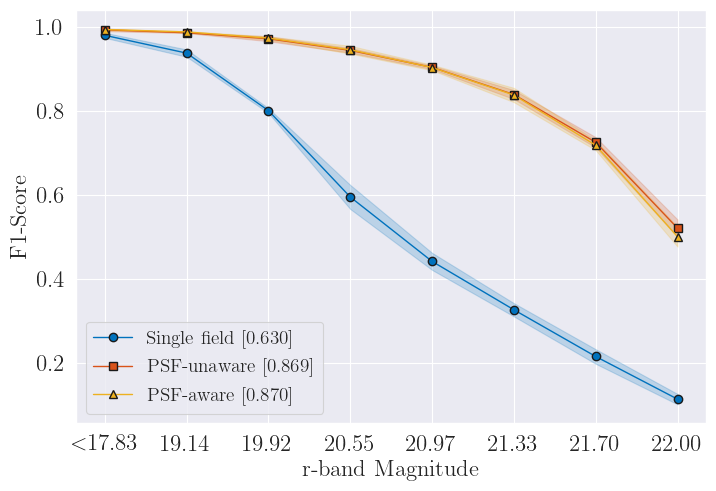

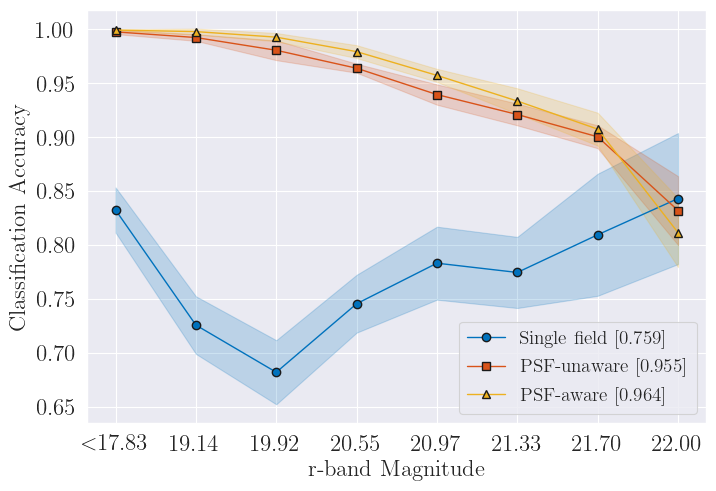

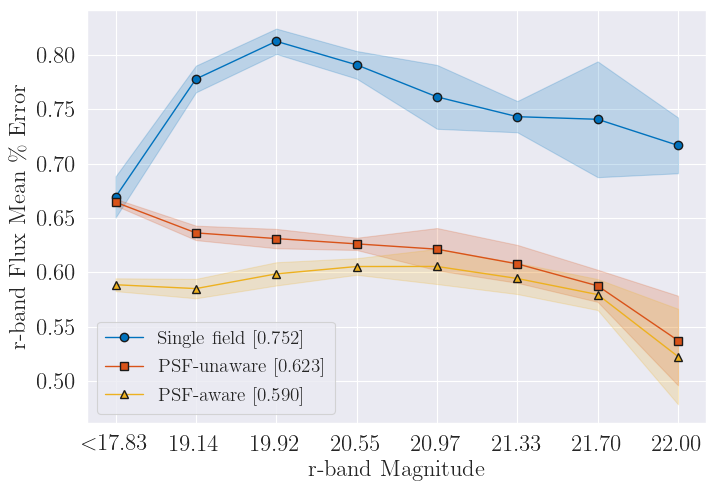

In [31]:
metrics_to_plot = {
    "precision": {"ylabel": "Precision"},
    "recall": {"ylabel": "Recall"},
    "f1": {"ylabel": "F1-Score"},
    "class_acc": {"ylabel": "Classification Accuracy"},
    "r_flux_mape": {"ylabel": "r-band Flux Mean \% Error"},
}

model_names = {
    "base": "Single field",
    "unaware": "PSF-unaware",
    "encode_params": "PSF-aware",
    # "overfit": "Overfit",
}

bins = cfg["encoder"]["metrics"]["metrics"][0]["mag_bin_cutoffs"]
exclude_last_bin = True
n_bins = len(bins)

xlabels = [f"{bins[i+1]:.2f}" for i in range(len(bins) - 1)]
xlabels.insert(0, f"$<${bins[0]:.2f}")

if not exclude_last_bin:
    xlabels.append(f"$>${bins[-1]:.2f}")
    n_bins += 1

markers = ["o", "s", "^"]

for metric, cfg_dict in metrics_to_plot.items():
    fig, ax = plt.subplots(figsize=(7.25, 5))

    for i, name in enumerate(model_names):
        if name not in data[metric].keys():
            continue

        binned_vals = [data[f"binned_{metric}_{j}"][name] for j in range(n_bins)]
        average_val = data[metric][name]
        label = f"{model_names[name]} [{average_val:.3f}]"
        ax.plot(
            binned_vals,
            c=COLORS[i],
            markeredgecolor="k",
            markersize=6,
            linewidth=1,
            marker=markers[i],
            label=label,
        )

        binned_stds = [data[f"binned_{metric}_{j}_std"][name] for j in range(n_bins)]
        mu, std = np.array(binned_vals), np.array(binned_stds)
        ax.fill_between(
            np.arange(len(mu)),
            mu-std,
            mu+std,
            color=COLORS[i],
            alpha=0.2
        )

    ax.set_xticks(range(len(xlabels)))
    ax.set_xticklabels(xlabels)
    ax.tick_params(axis="both", which="major", labelsize="xx-large")
    ax.set_xlabel("r-band Magnitude", fontsize="xx-large")
    ax.set_ylabel(cfg_dict["ylabel"], fontsize="xx-large")

    # ax.set_title(metric, fontsize=10)
    ax.legend(fontsize="x-large")

    fig.tight_layout()
    plt.savefig(f"plots/single_field/binned_{metric}.pdf")

### Plot doubly-binned results

In [30]:
data = torch.load("overfit_all.pt")

In [35]:
metrics_to_plot = {
    "disk_hlr": {"ylabel": "Disk HLR Mean \% Error", "xlabel": "Disk HLR (arcsec)"},
    "bulge_hlr": {"ylabel": "Bulge HLR Mean \% Error", "xlabel": "Bulge HLR (arcsec)"},
    "disk_frac": {"ylabel": "Disk Fraction Mean \% Error", "xlabel": "Disk Fraction"},
    "beta_radians": {"ylabel": "Position Angle Mean \% Error", "xlabel": "Position Angle (radians)"},
}

model_names = {
    # "base": "Single field",
    # "unaware": "PSF-unaware",
    # "encode_params": "PSF encoding",
    "overfit": "Overfit",
}

gal_shape_metric_cfg = cfg["encoder"]["metrics"]["metrics"][3]
mag_bin_cutoffs = gal_shape_metric_cfg["mag_bin_cutoffs"]
param_bin_cutoffs = gal_shape_metric_cfg["param_bin_cutoffs"]
exclude_last_mag_bin = gal_shape_metric_cfg["exclude_last_bin"]
exlude_last_param_bin = True

markers = ["o", "s", "^"]

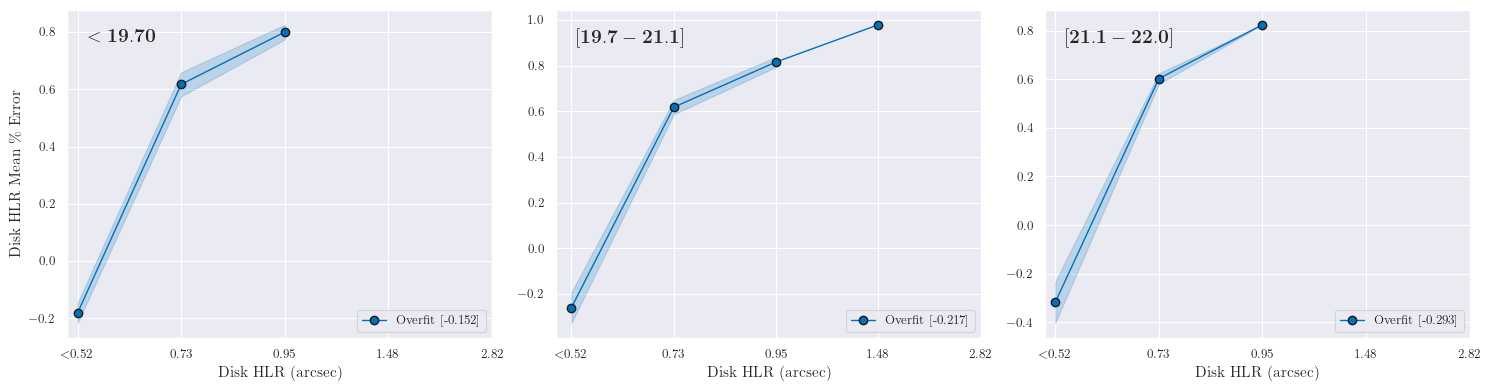

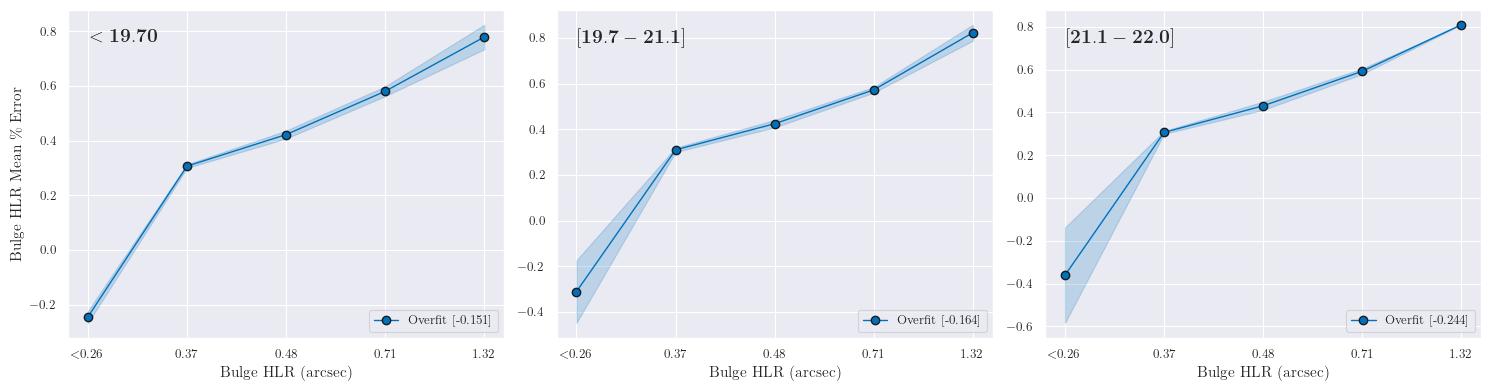

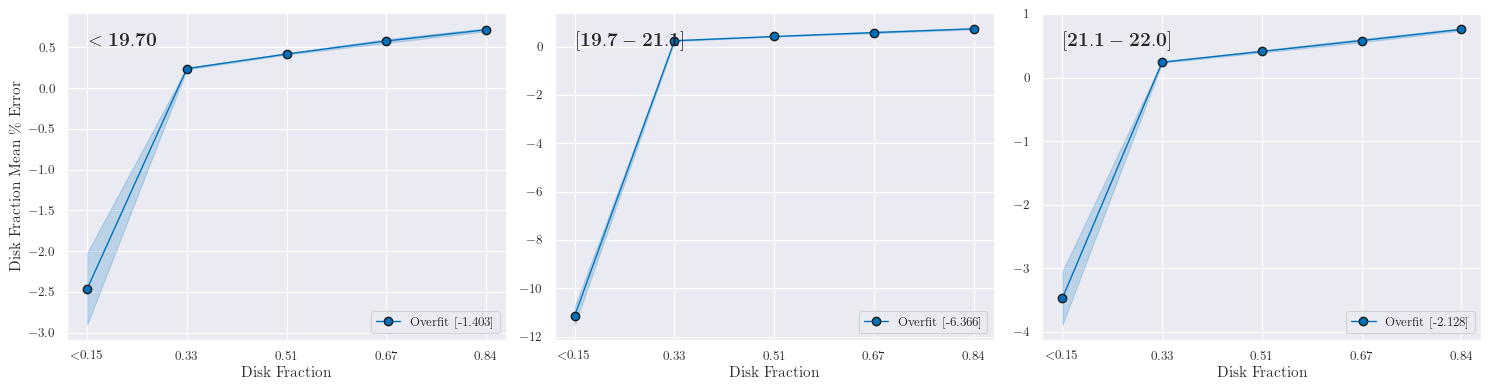

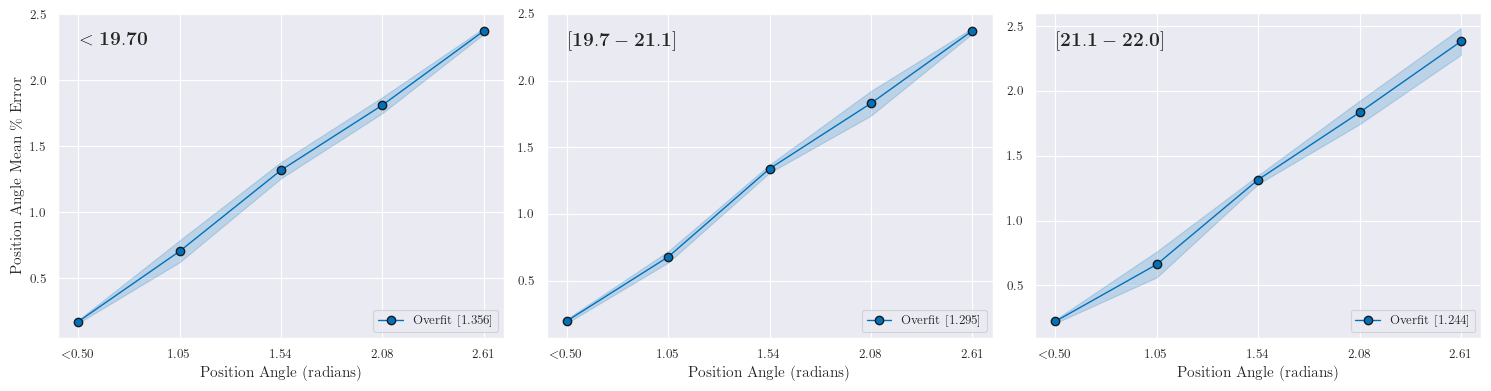

In [36]:
for param, cfg_dict in metrics_to_plot.items():
    # overall error:                    param_mape
    # error in mag bin i:               param_mape_mag_i
    # error in mag bin i, param bin i:  param_mape_mag_i_j
    metric = f"{param}_mape"
    
    # Generate labels for mag bins and parameter bins
    param_bins = param_bin_cutoffs[param]
    n_param_bins = len(param_bins)
    xlabels = [f"{param_bins[i+1]:.2f}" for i in range(len(param_bins) - 1)]
    xlabels.insert(0, f"$<${param_bins[0]:.2f}")
    if not exlude_last_param_bin:
        xlabels.append(f"$>${param_bins[-1]:.2f}")
        n_param_bins += 1

    mag_bin_labels = [
        f"[{mag_bin_cutoffs[i]:.1f}-{mag_bin_cutoffs[i+1]:.1f}]"
        for i in range(len(mag_bin_cutoffs)-1)
    ]
    mag_bin_labels.insert(0, f"<{mag_bin_cutoffs[0]:.2f}")
    n_mag_bins = len(mag_bin_cutoffs)
    if not exclude_last_bin:
        mag_bin_labels.append(f">{mag_bin_cutoffs[-1]:.2f}")
        n_mag_bins += 1

    fig, ax = plt.subplots(1, n_mag_bins, figsize=(5*n_mag_bins, 4))
    for mag_bin in range(n_mag_bins):
        # add mag bin annotation
        annotation = mag_bin_labels[mag_bin]
        ax[mag_bin].text(0.05, 0.9, f"$\\mathbf{{{annotation}}}$", fontsize=14, transform=ax[mag_bin].transAxes)

        for model_idx, name in enumerate(model_names):
            if name not in data[metric].keys():
                continue
            
            # get vals in mag bin binned by parameter 
            binned_vals = [
                data[f"binned_{metric}_mag_{mag_bin}_{j}"][name]
                for j in range(n_param_bins)
            ]
            average_val = data[f"{metric}_mag_{mag_bin}"][name]
            label = f"{model_names[name]} [{average_val:.3f}]"
            ax[mag_bin].plot(
                binned_vals,
                c=COLORS[model_idx],
                markeredgecolor="k",
                markersize=6,
                linewidth=1,
                marker=markers[model_idx],
                label=label
            )

            binned_stds = [
                data[f"binned_{metric}_mag_{mag_bin}_{j}_std"][name]
                for j in range(n_param_bins)
            ]
            mu, std = np.array(binned_vals), np.array(binned_stds)
            ax[mag_bin].fill_between(
                np.arange(len(mu)),
                mu-std,
                mu+std,
                color=COLORS[model_idx],
                alpha=0.2
            )

        ax[mag_bin].set_xticks(range(len(xlabels)), xlabels)
        ax[mag_bin].set_xlabel(cfg_dict["xlabel"], fontsize=11)

        # ax.set_title(metric, fontsize=10)
        ax[mag_bin].legend(loc="lower right")

    ax[0].set_ylabel(cfg_dict["ylabel"], fontsize=11)
    fig.tight_layout()
    # plt.savefig(f"plots/multi_field/binned_{metric}.pdf")

# Random testing

## Testing bins

In [8]:
metric_update = torch.load("temp.pt")
true_cat = metric_update["true_cat"].to("cpu")
est_cat = metric_update["est_cat"].to("cpu")
matching = metric_update["matching"]

In [29]:
from bliss.encoder.metrics import GalaxyShapeError

param_bin_cutoffs = {
    "disk_frac": [0.13, 0.25, 0.38, 0.50, 0.62, 0.75, 0.88],
    "beta_radians": [0.4, 0.8, 1.2, 1.6, 2.0, 2.4, 2.8],
    "disk_q": [0.12, 0.25, 0.37, 0.50, 0.62, 0.75, 0.87],
    "a_d": [0.85, 0.94, 1.12, 1.45, 2.03, 3.02, 5.11],
    "bulge_q": [0.12, 0.25, 0.38, 0.50, 0.63, 0.75, 0.88],
    "a_b": [0.43, 0.47, 0.56, 0.73, 1.02, 1.51, 2.53],
    "disk_hlr": [0.45, 0.64, 0.78, 0.95, 1.30, 1.97, 3.43],
    "bulge_hlr": [0.22, 0.32, 0.39, 0.48, 0.66, 0.99, 1.71],
}

metric = GalaxyShapeError(
    mag_bin_cutoffs=[19.7, 21.1, 22],
    param_bin_cutoffs=param_bin_cutoffs,
    exclude_last_bin=True
)

In [ ]:
metric.update(true_cat, est_cat, matching)
metric.compute()
metric.reset()

In [49]:
environ["BLISS_HOME"] = "~/bliss"
with initialize(config_path=".", version_base=None):
    cfg = compose("config")

In [50]:
encoder = instantiate(cfg.encoder)

In [51]:
encoder.vd_spec.factor_specs

{'on_prob': <bliss.encoder.unconstrained_dists.UnconstrainedBernoulli at 0x7f8f00603fa0>,
 'loc': <bliss.encoder.unconstrained_dists.UnconstrainedTDBN at 0x7f8f006008b0>,
 'galaxy_prob': <bliss.encoder.unconstrained_dists.UnconstrainedBernoulli at 0x7f8f00600970>,
 'galsim_disk_frac': <bliss.encoder.unconstrained_dists.UnconstrainedLogitNormal at 0x7f8f006009d0>,
 'galsim_beta_radians': <bliss.encoder.unconstrained_dists.UnconstrainedLogitNormal at 0x7f8f00600a90>,
 'galsim_disk_hlr': <bliss.encoder.unconstrained_dists.UnconstrainedLogNormal at 0x7f8f00600af0>,
 'galsim_bulge_hlr': <bliss.encoder.unconstrained_dists.UnconstrainedLogNormal at 0x7f8f00600b50>,
 'star_flux_r': <bliss.encoder.unconstrained_dists.UnconstrainedLogNormal at 0x7f8f00600c40>,
 'galaxy_flux_r': <bliss.encoder.unconstrained_dists.UnconstrainedLogNormal at 0x7f8f00600ca0>}

In [55]:
test_dataset.slices[0] = slice(0, 1024)
test_dataset.slices[1] = slice(0, 1024)

# Calibration metrics

In [143]:
temp_dataloader = DataLoader(test_dataset.test_dataloader().dataset[:1024], batch_size=64, shuffle=False)

In [9]:
pred = {}
for name, model in models.items():
    pred[name] = trainer.predict(model["encoder"], test_dataset.test_dataloader())

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4]


Predicting: 0it [00:00, ?it/s]

### Expected number of sources

In [157]:
bins = torch.arange(20)
n_bins = len(bins) + 1

sum_all = { name: torch.zeros(n_bins) for name in models }
all_count = { name: torch.zeros(n_bins) for name in models }

sum_bright = { name: torch.zeros(n_bins) for name in models }
bright_count = { name: torch.zeros(n_bins) for name in models }

sum_dim = { name: torch.zeros(n_bins) for name in models }
dim_count = { name: torch.zeros(n_bins) for name in models }

for i, batch in enumerate(temp_dataloader):
    target_cat = TileCatalog(4, batch["tile_catalog"])
    target_cat = target_cat.symmetric_crop(1)

    normal_mask = (target_cat.magnitudes[..., 2] < 22).squeeze()
    bright_mask = (target_cat.magnitudes[..., 2] < 17.8).squeeze()
    dim_mask = (target_cat.magnitudes[..., 2] > 20).squeeze() * normal_mask

    true_sources = (target_cat.n_sources.bool() * normal_mask).sum(dim=(1,2))
    true_bright = (target_cat.n_sources.bool() * bright_mask).sum(dim=(1,2))
    true_dim = (target_cat.n_sources.bool() * dim_mask).sum(dim=(1,2))

    binned_true = torch.bucketize(true_sources, bins)
    binned_bright = torch.bucketize(true_bright, bins)
    binned_dim = torch.bucketize(true_dim, bins)

    for name in models:
        pred_cat = pred[name][i]["sample_cat"]
        all_pred = pred_cat.n_sources.sum(dim=(1,2))
        bright_pred = (pred_cat.n_sources * bright_mask).sum(dim=(1,2))
        dim_pred = (pred_cat.n_sources * dim_mask).sum(dim=(1,2))
    
        tmp = torch.zeros(n_bins, dtype=int)
        sum_all[name] += tmp.scatter_add(0, binned_true, all_pred)
        all_count[name] += binned_true.bincount(minlength=n_bins)

        tmp = torch.zeros(n_bins, dtype=int)
        sum_bright[name] += tmp.scatter_add(0, binned_bright, bright_pred)
        bright_count[name] += binned_bright.bincount(minlength=n_bins)

        tmp = torch.zeros(n_bins, dtype=int)
        sum_dim[name] += tmp.scatter_add(0, binned_dim, dim_pred)
        dim_count[name] += binned_dim.bincount(minlength=n_bins)

mean_sources_per_bin = {}
mean_bright_per_bin = {}
mean_dim_per_bin = {}
for name in models:
    mean_sources_per_bin[name] = sum_all[name] / all_count[name]
    mean_bright_per_bin[name] = sum_bright[name] / bright_count[name]
    mean_dim_per_bin[name] = sum_dim[name] / dim_count[name]

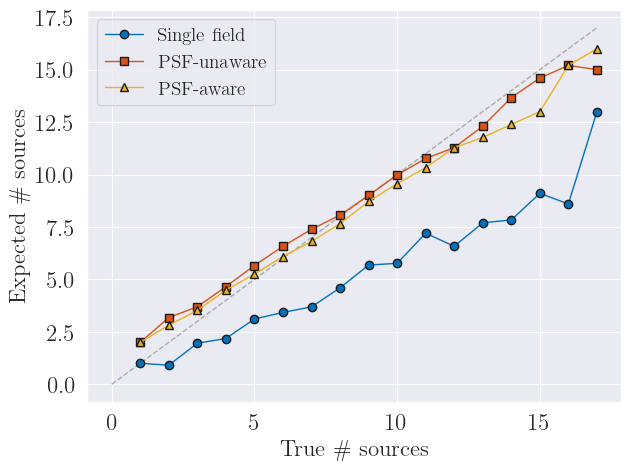

In [161]:
fig, ax = plt.subplots()
max_n_all = max([torch.argmax(torch.arange(n_bins) * ~mean_sources_per_bin[name].isnan()) for name in models])
ax.plot(torch.arange(max_n_all + 1), c="darkgray", linewidth=1, linestyle="dashed")
ax.plot(mean_sources_per_bin["base"], c=COLORS[0], marker="o", markeredgecolor="k", markersize=6, linewidth=1, label="Single field")
ax.plot(mean_sources_per_bin["unaware"], c=COLORS[1], marker="s", markeredgecolor="k", markersize=6, linewidth=1, label="PSF-unaware")
ax.plot(mean_sources_per_bin["encode_params"], c=COLORS[2], marker="^", markeredgecolor="k", markersize=6, linewidth=1, label="PSF-aware")

ax.tick_params(axis="both", which="major", labelsize="xx-large")
ax.set_xlabel("True \# sources", fontsize="xx-large")
ax.set_ylabel("Expected \# sources", fontsize="xx-large")
ax.legend(fontsize="x-large")

fig.tight_layout()
plt.savefig("plots/calib/sources_true_vs_expected.pdf")

In [162]:
data = {
    "mean_sources_per_bin": mean_sources_per_bin,
    "mean_bright_per_bin": mean_bright_per_bin,
    "mean_dim_per_bin": mean_dim_per_bin,
}
torch.save(data, "expected_sources.pt")

In [164]:
data = torch.load("expected_sources.pt")
mean_sources_per_bin = data["mean_sources_per_bin"]
mean_bright_per_bin = data["mean_bright_per_bin"]
mean_dim_per_bin = data["mean_dim_per_bin"]

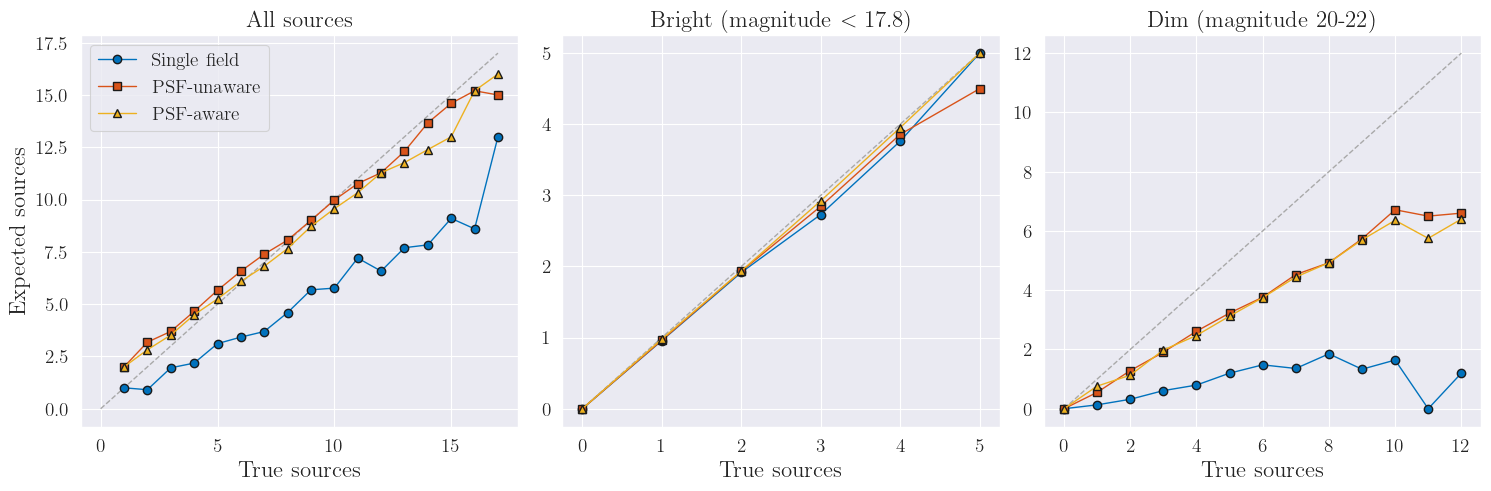

In [167]:
fig, ax = plt.subplots(1, 3, figsize=(5*3, 5))

bins = torch.arange(20)
n_bins = len(bins) + 1

# All
max_n_all = max([torch.argmax(torch.arange(n_bins) * ~mean_sources_per_bin[name].isnan()) for name in models])
ax[0].plot(torch.arange(max_n_all + 1), c="darkgray", linewidth=1, linestyle="dashed")
ax[0].plot(mean_sources_per_bin["base"], c=COLORS[0], marker="o", markeredgecolor="k", markersize=6, linewidth=1, label="Single field")
ax[0].plot(mean_sources_per_bin["unaware"], c=COLORS[1], marker="s", markeredgecolor="k", markersize=6, linewidth=1, label="PSF-unaware")
ax[0].plot(mean_sources_per_bin["encode_params"], c=COLORS[2], marker="^", markeredgecolor="k", markersize=6, linewidth=1, label="PSF-aware")

ax[0].legend(fontsize="x-large")
ax[0].set_title("All sources", fontsize="xx-large")
# ax[0].text(0.98, 0.05, f"$\\textbf{{All sources}}$", horizontalalignment='right', fontsize=14, fontweight="bold", transform=ax[0].transAxes)

# Bright
max_n_bright = max([torch.argmax(torch.arange(n_bins) * ~mean_bright_per_bin[name].isnan()) for name in models])
ax[1].plot(torch.arange(max_n_bright + 1), c="darkgray", linewidth=1, linestyle="dashed")
ax[1].plot(mean_bright_per_bin["base"], c=COLORS[0], marker="o", markeredgecolor="k", markersize=6, linewidth=1, label="Single field")
ax[1].plot(mean_bright_per_bin["unaware"], c=COLORS[1], marker="s", markeredgecolor="k", markersize=6, linewidth=1, label="PSF-unaware")
ax[1].plot(mean_bright_per_bin["encode_params"], c=COLORS[2], marker="^", markeredgecolor="k", markersize=6, linewidth=1, label="PSF-aware")

ax[1].set_title(f"Bright (magnitude $< 17.8$)", fontsize="xx-large")
# ax[1].text(0.98, 0.05, f"$\\textbf{{Bright (magnitude}}\\mathbf{{<}}\\textbf{{17.8)}}$", horizontalalignment='right', fontsize=14, transform=ax[1].transAxes)

# Dim
max_n_dim = max([torch.argmax(torch.arange(n_bins) * ~mean_dim_per_bin[name].isnan()) for name in models])
ax[2].plot(torch.arange(max_n_dim + 1), c="darkgray", linewidth=1, linestyle="dashed")
ax[2].plot(mean_dim_per_bin["base"], c=COLORS[0], marker="o", markeredgecolor="k", markersize=6, linewidth=1, label="Single field")
ax[2].plot(mean_dim_per_bin["unaware"], c=COLORS[1], marker="s", markeredgecolor="k", markersize=6, linewidth=1, label="PSF-unaware")
ax[2].plot(mean_dim_per_bin["encode_params"], c=COLORS[2], marker="^", markeredgecolor="k", markersize=6, linewidth=1, label="PSF-aware")

ax[2].set_title(f"Dim (magnitude 20-22)", fontsize="xx-large")
# ax[2].text(0.98, 0.9, f"$\\textbf{{Dim (magnitude 21-22)}}$)", horizontalalignment='right', fontsize=14, fontweight="bold", transform=ax[2].transAxes)

for a in ax:
    a.tick_params(axis="both", which="major", labelsize="x-large")
    a.set_xlabel("True sources", fontsize="xx-large")
ax[0].set_ylabel("Expected sources", fontsize="xx-large")

fig.tight_layout()
plt.savefig("plots/calib/sources_true_vs_expected_by_mag.pdf")

#### sum probs

In [155]:
bins = torch.arange(30)
n_bins = len(bins) + 1

sum_sources = { name: torch.zeros(n_bins) for name in models }
bin_count = { name: torch.zeros(n_bins) for name in models }

for i, batch in enumerate(temp_dataloader):
    target_cat = TileCatalog(4, batch["tile_catalog"])
    target_cat = target_cat.filter_tile_catalog_by_flux(min_flux=1.59)
    true_sources = target_cat.n_sources.sum(dim=(1,2))
    binned_true_sources = torch.bucketize(true_sources, bins)
    

    for name, model in models.items():
        pred = model["encoder"].infer(batch, lambda pred_marginal: pred_marginal.sample(use_mode=False))
        source_probs_marginal = pred["marginal"].factors["on_prob"].probs[..., 1]
        source_probs_conditional = pred["white"].factors["on_prob"].probs[..., 1]
        mask = pred["white_history_mask"]

        mean_pred_sources = (source_probs_marginal * mask).sum(dim=(1,2))
        mean_pred_sources += (source_probs_conditional * (1-mask)).sum(dim=(1,2))

        sources_per_bin = torch.zeros(n_bins, dtype=mean_pred_sources.dtype)
        sum_sources[name] += sources_per_bin.scatter_add(0, binned_true_sources, mean_pred_sources)
        bin_count[name] += binned_true_sources.bincount(minlength=n_bins)

mean_sources_per_bin = {}
for name in models:
    mean_sources_per_bin[name] = sum_sources[name] / bin_count[name]

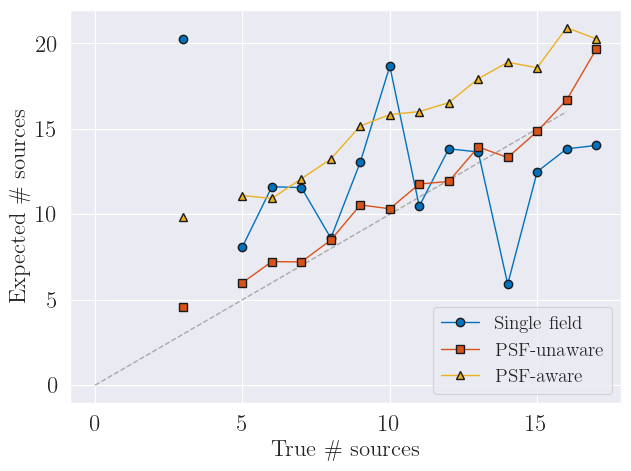

In [156]:
fig, ax = plt.subplots()
ax.plot(torch.arange(17), c="darkgray", linewidth=1, linestyle="dashed")
ax.plot(mean_sources_per_bin["base"].detach(), c=COLORS[0], marker="o", markeredgecolor="k", markersize=6, linewidth=1, label="Single field")
ax.plot(mean_sources_per_bin["unaware"].detach(), c=COLORS[1], marker="s", markeredgecolor="k", markersize=6, linewidth=1, label="PSF-unaware")
ax.plot(mean_sources_per_bin["encode_params"].detach(), c=COLORS[2], marker="^", markeredgecolor="k", markersize=6, linewidth=1, label="PSF-aware")

ax.tick_params(axis="both", which="major", labelsize="xx-large")
ax.set_xlabel("True \# sources", fontsize="xx-large")
ax.set_ylabel("Expected \# sources", fontsize="xx-large")
ax.legend(fontsize="x-large")

fig.tight_layout()

### Flux prob

#### Probability predicted magnitude is within x of true magnitude

In [114]:
bins = torch.tensor([17.826, 19.138, 19.921, 20.549, 20.970, 21.332, 21.703, 22])
n_bins = len(bins) + 1

sum_probs = { name: torch.zeros(n_bins) for name in models }
bin_count = { name: torch.zeros(n_bins) for name in models }

for batch in tqdm(temp_dataloader):
    target_cat = TileCatalog(4, batch["tile_catalog"])
    target_cat = target_cat.filter_tile_catalog_by_flux(min_flux=1.59)

    target_mags = target_cat.magnitudes
    lb = convert_mag_to_nmgy(target_mags + 1)[..., 2].squeeze()
    ub = convert_mag_to_nmgy(target_mags - 1)[..., 2].squeeze()

    target_on_mags = target_mags[target_cat.is_on_mask][:, 2]
    binned_target_on_mags = torch.bucketize(target_on_mags, bins)

    for name, model in models.items():
        pred = model["encoder"].infer(batch, lambda _: target_cat)
        star_marg = pred["marginal"].factors["star_flux_r"]
        star_cond = pred["white"].factors["star_flux_r"]

        gal_marg = pred["marginal"].factors["galaxy_flux_r"]
        gal_cond = pred["white"].factors["galaxy_flux_r"]

        star_marg_probs = star_marg.cdf(ub) - star_marg.cdf(lb)
        star_cond_probs = star_cond.cdf(ub) - star_cond.cdf(lb)
        gal_marg_probs = gal_marg.cdf(ub) - gal_marg.cdf(lb)
        gal_cond_probs = gal_cond.cdf(ub) - gal_cond.cdf(lb)

        mask = pred["white_history_mask"]

        star_probs = star_marg_probs * mask + star_cond_probs * (1 - mask)
        gal_probs = gal_marg_probs * mask + gal_cond_probs * (1 - mask)

        pred_probs = torch.where(target_cat.star_bools.squeeze(), star_probs, gal_probs)
        pred_probs = pred_probs.unsqueeze(-1)[target_cat.is_on_mask]

        probs_per_bin = torch.zeros(n_bins, dtype=pred_probs.dtype)
        sum_probs[name] += probs_per_bin.scatter_add(0, binned_target_on_mags, pred_probs)
        bin_count[name] += binned_target_on_mags.bincount(minlength=n_bins)

binned_avg_flux_probs = {}
for name in models:
    binned_avg_flux_probs[name] = sum_probs[name] / bin_count[name]

  0%|          | 0/16 [00:00<?, ?it/s]

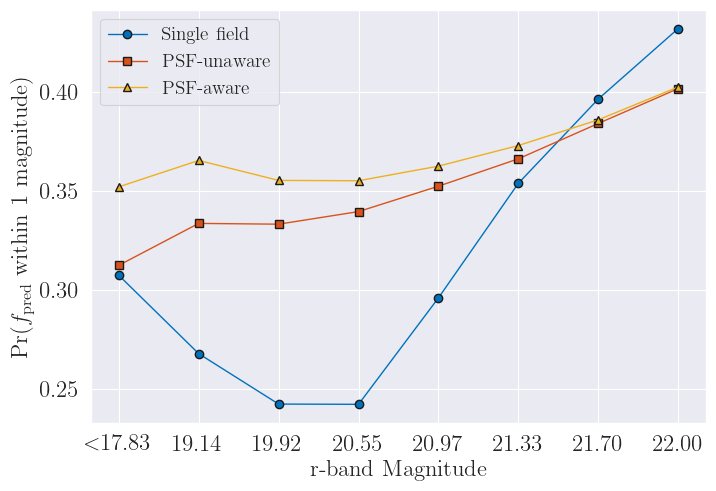

In [116]:
model_names = {
    "base": "Single field",
    "unaware": "PSF-unaware",
    "encode_params": "PSF-aware",
}

bins = torch.tensor([17.826, 19.138, 19.921, 20.549, 20.970, 21.332, 21.703, 22])
exclude_last_bin = True
n_bins = len(bins)

xlabels = [f"{bins[i+1]:.2f}" for i in range(len(bins) - 1)]
xlabels.insert(0, f"$<${bins[0]:.2f}")

if not exclude_last_bin:
    xlabels.append(f"$>${bins[-1]:.2f}")
    n_bins += 1

markers = ["o", "s", "^"]

fig, ax = plt.subplots(figsize=(7.25, 5))

for i, name in enumerate(model_names):
    if name not in binned_avg_flux_probs:
        continue

    binned_vals = binned_avg_flux_probs[name].detach()
    label = f"{model_names[name]}"
    ax.plot(
        binned_vals,
        c=COLORS[i],
        markeredgecolor="k",
        markersize=6,
        linewidth=1,
        marker=markers[i],
        label=label,
    )

ax.set_xticks(range(len(xlabels)))
ax.set_xticklabels(xlabels)
ax.tick_params(axis="both", which="major", labelsize="xx-large")
ax.set_xlabel("r-band Magnitude", fontsize="xx-large")
ax.set_ylabel("Pr($f_{\mathrm{pred}}$ within 1 magnitude)", fontsize="xx-large")
ax.legend(fontsize="x-large")

fig.tight_layout()
plt.savefig(f"plots/calib/prob_flux_within_1_mag.pdf")

In [117]:
torch.save(binned_avg_flux_probs, "binned_avg_flux_probs.pt")

#### Proportion of true fluxes in credible interval

In [148]:
intervals = torch.linspace(0.5, 1, 11)

sum_all_in_eti = { name: torch.zeros(len(intervals)) for name in models }
sum_bright_in_eti = { name: torch.zeros(len(intervals)) for name in models }
sum_dim_in_eti = { name: torch.zeros(len(intervals)) for name in models }
all_count = 0
bright_count = 0
dim_count = 0

for batch in tqdm(temp_dataloader):
    target_cat = TileCatalog(4, batch["tile_catalog"])
    target_cat = target_cat.filter_tile_catalog_by_flux(min_flux=1.59)
    true_fluxes = target_cat.on_fluxes[..., 0, 2]

    bright_mask = (target_cat.magnitudes[..., 2] < 17.8).squeeze()
    dim_mask = (target_cat.magnitudes[..., 2] > 20).squeeze()

    all_count += target_cat.n_sources.sum()
    bright_count += bright_mask.sum()
    dim_count += dim_mask.sum()

    for name, model in models.items():
        pred = model["encoder"].infer(batch, lambda _: target_cat)

        star_marg = pred["marginal"].factors["star_flux_r"]
        star_cond = pred["white"].factors["star_flux_r"]
        gal_marg = pred["marginal"].factors["galaxy_flux_r"]
        gal_cond = pred["white"].factors["galaxy_flux_r"]

        for j, interval in enumerate(intervals):
            # construct equal tail intervals and determine if true flux is within ETI
            tail_prob = (1 - interval) / 2
            star_marg_in_eti = (true_fluxes >= star_marg.icdf(tail_prob)) & (true_fluxes <= star_marg.icdf(1 - tail_prob))
            star_cond_in_eti = (true_fluxes >= star_cond.icdf(tail_prob)) & (true_fluxes <= star_cond.icdf(1 - tail_prob))
            gal_marg_in_eti = (true_fluxes >= gal_marg.icdf(tail_prob)) & (true_fluxes <= gal_marg.icdf(1 - tail_prob))
            gal_cond_in_eti = (true_fluxes >= gal_cond.icdf(tail_prob)) & (true_fluxes <= gal_cond.icdf(1 - tail_prob))

            mask = pred["white_history_mask"]

            star_in_eti = star_marg_in_eti * mask + star_cond_in_eti * (1 - mask)
            gal_in_eti = gal_marg_in_eti * mask + gal_cond_in_eti * (1 - mask)
            source_in_eti = torch.where(target_cat.star_bools.squeeze(), star_in_eti, gal_in_eti)

            sum_all_in_eti[name][j] += (source_in_eti * target_cat.is_on_mask.squeeze()).sum()
            sum_bright_in_eti[name][j] += (source_in_eti * bright_mask).sum()
            sum_dim_in_eti[name][j] += (source_in_eti * dim_mask).sum()

prop_all_in_eti = {}
prop_bright_in_eti = {}
prop_dim_in_eti = {}
for name in models:
    prop_all_in_eti[name] = sum_all_in_eti[name] / all_count
    prop_bright_in_eti[name] = sum_bright_in_eti[name] / bright_count
    prop_dim_in_eti[name] = sum_dim_in_eti[name] / dim_count

  0%|          | 0/16 [00:00<?, ?it/s]

In [169]:
data = {
    "prop_all_in_eti": prop_all_in_eti,
    "prop_bright_in_eti": prop_bright_in_eti,
    "prop_dim_in_eti": prop_dim_in_eti
}
torch.save(data, "prop_flux_in_interval.pt")

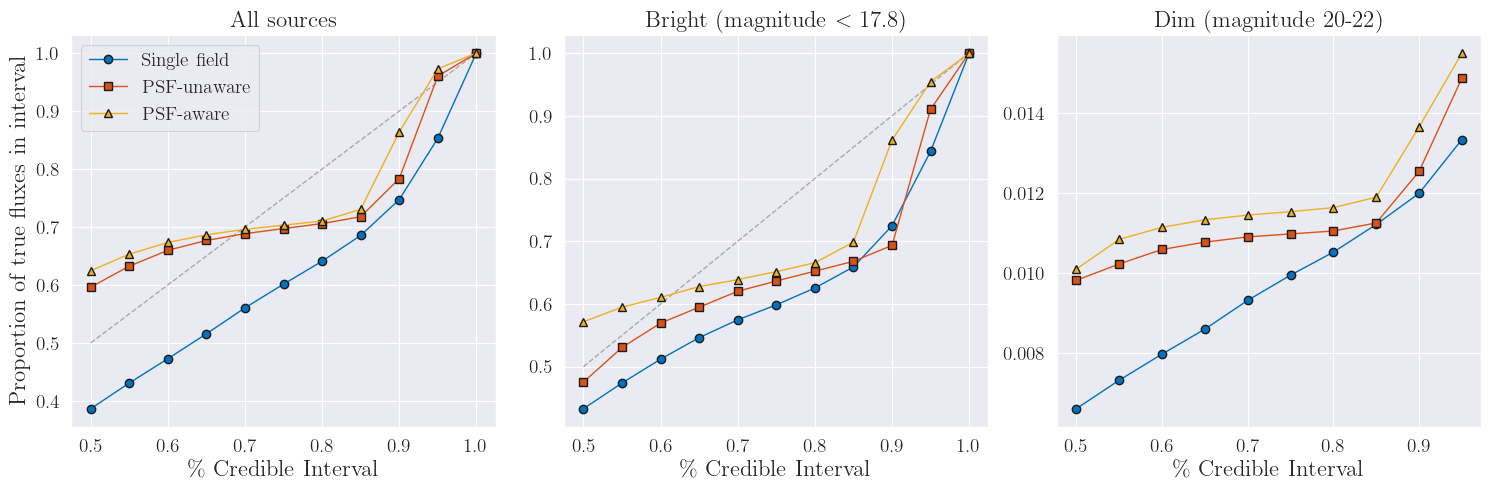

In [158]:
fig, ax = plt.subplots(1, 3, figsize=(5*3, 5))

# All
ax[0].plot(intervals, intervals, color="darkgray", linewidth=1, linestyle="dashed")
ax[0].plot(intervals, prop_all_in_eti["base"], c=COLORS[0], marker="o", markeredgecolor="k", markersize=6, linewidth=1, label="Single field")
ax[0].plot(intervals, prop_all_in_eti["unaware"], c=COLORS[1], marker="s", markeredgecolor="k", markersize=6, linewidth=1, label="PSF-unaware")
ax[0].plot(intervals, prop_all_in_eti["encode_params"], c=COLORS[2], marker="^", markeredgecolor="k", markersize=6, linewidth=1, label="PSF-aware")

ax[0].legend(fontsize="x-large")
ax[0].set_title("All sources", fontsize="xx-large")

# Bright
ax[1].plot(intervals, intervals, color="darkgray", linewidth=1, linestyle="dashed")
ax[1].plot(intervals, prop_bright_in_eti["base"], c=COLORS[0], marker="o", markeredgecolor="k", markersize=6, linewidth=1, label="Single field")
ax[1].plot(intervals, prop_bright_in_eti["unaware"], c=COLORS[1], marker="s", markeredgecolor="k", markersize=6, linewidth=1, label="PSF-unaware")
ax[1].plot(intervals, prop_bright_in_eti["encode_params"], c=COLORS[2], marker="^", markeredgecolor="k", markersize=6, linewidth=1, label="PSF-aware")

ax[1].set_title(f"Bright (magnitude $< 17.8$)", fontsize="xx-large")

# Dim
ax[2].plot(intervals[:-1], prop_dim_in_eti["base"][:-1], c=COLORS[0], marker="o", markeredgecolor="k", markersize=6, linewidth=1, label="Single field")
ax[2].plot(intervals[:-1], prop_dim_in_eti["unaware"][:-1], c=COLORS[1], marker="s", markeredgecolor="k", markersize=6, linewidth=1, label="PSF-unaware")
ax[2].plot(intervals[:-1], prop_dim_in_eti["encode_params"][:-1], c=COLORS[2], marker="^", markeredgecolor="k", markersize=6, linewidth=1, label="PSF-aware")

ax[2].set_title(f"Dim (magnitude 20-22)", fontsize="xx-large")

for a in ax:
    a.tick_params(axis="both", which="major", labelsize="x-large")
    a.set_xlabel("\% Credible Interval", fontsize="xx-large")
ax[0].set_ylabel("Proportion of true fluxes in interval", fontsize="xx-large")

fig.tight_layout()
plt.savefig("plots/calib/prop_flux_in_interval_by_mag.pdf")

### Source Type

#### Prob source type by magnitude

In [92]:
bins = torch.tensor([17.826, 19.138, 19.921, 20.549, 20.970, 21.332, 21.703, 22])
n_bins = len(bins) + 1

sum_probs = { name: torch.zeros(n_bins) for name in models }
bin_count = { name: torch.zeros(n_bins) for name in models }

for i, batch in enumerate(temp_dataloader):
    target_cat = TileCatalog(4, batch["tile_catalog"])
    target_cat = target_cat.filter_tile_catalog_by_flux(min_flux=1.59)

    target_mags = target_cat.magnitudes
    target_on_mags = target_mags[target_cat.is_on_mask][:, 2]
    binned_target_on_mags = torch.bucketize(target_on_mags, bins)

    target_types = target_cat["source_type"].squeeze().bool()

    for name, model in models.items():
        pred = model["encoder"].infer(batch, lambda _: target_cat)

        gal_prob_marginal = pred["marginal"].factors["galaxy_prob"].probs[..., 1]
        gal_prob_conditional = pred["marginal"].factors["galaxy_prob"].probs[..., 1]
        mask = pred["white_history_mask"]

        gal_probs = gal_prob_marginal * mask + (gal_prob_conditional * (1 - mask))
        true_type_prob = torch.where(target_types, gal_probs, 1 - gal_probs)
        on_gal_probs = true_type_prob[target_cat.is_on_mask.squeeze()]

        probs_per_bin = torch.zeros(n_bins, dtype=true_type_prob.dtype)
        sum_probs[name] += probs_per_bin.scatter_add(0, binned_target_on_mags, on_gal_probs)
        bin_count[name] += binned_target_on_mags.bincount(minlength=n_bins)

binned_avg_probs = {}
for name in models:
    binned_avg_probs[name] = sum_probs[name] / bin_count[name]

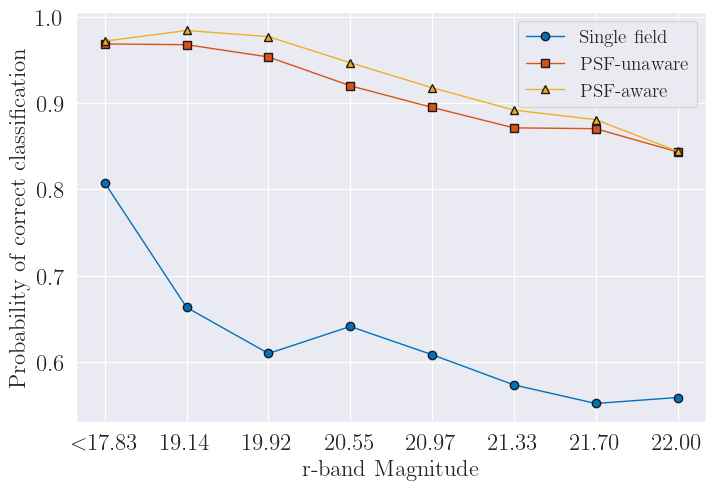

In [96]:
model_names = {
    "base": "Single field",
    "unaware": "PSF-unaware",
    "encode_params": "PSF-aware",
}

bins = torch.tensor([17.826, 19.138, 19.921, 20.549, 20.970, 21.332, 21.703, 22])
exclude_last_bin = True
n_bins = len(bins)

xlabels = [f"{bins[i+1]:.2f}" for i in range(len(bins) - 1)]
xlabels.insert(0, f"$<${bins[0]:.2f}")

if not exclude_last_bin:
    xlabels.append(f"$>${bins[-1]:.2f}")
    n_bins += 1

markers = ["o", "s", "^"]

fig, ax = plt.subplots(figsize=(7.25, 5))

for i, name in enumerate(model_names):
    if name not in binned_avg_probs:
        continue

    binned_vals = binned_avg_probs[name].detach()
    label = f"{model_names[name]}"
    ax.plot(
        binned_vals,
        c=COLORS[i],
        markeredgecolor="k",
        markersize=6,
        linewidth=1,
        marker=markers[i],
        label=label,
    )

ax.set_xticks(range(len(xlabels)))
ax.set_xticklabels(xlabels)
ax.tick_params(axis="both", which="major", labelsize="xx-large")
ax.set_xlabel("r-band Magnitude", fontsize="xx-large")
ax.set_ylabel("Probability of correct classification", fontsize="xx-large")
ax.legend(fontsize="x-large")

fig.tight_layout()
plt.savefig(f"plots/multi_field/calib_source_type.pdf")

#### Prob correct galaxy by threshold

In [74]:
thresholds = torch.linspace(0, 1, 11)

pred_all_gal = { name: torch.zeros(len(thresholds)) for name in models }
pred_bright_gal = { name: torch.zeros(len(thresholds)) for name in models }
pred_dim_gal = { name: torch.zeros(len(thresholds)) for name in models }

true_all = 0
true_bright = 0
true_dim = 0

for batch in tqdm(temp_dataloader):
    target_cat = TileCatalog(4, batch["tile_catalog"])
    target_cat = target_cat.filter_tile_catalog_by_flux(min_flux=1.59)

    bright_mask = (target_cat.magnitudes[..., 2] < 17.8).squeeze()
    dim_mask = (target_cat.magnitudes[..., 2] > 20).squeeze()

    true_all += target_cat.galaxy_bools.sum()
    true_bright += (target_cat.galaxy_bools.squeeze() * bright_mask).sum()
    true_dim += (target_cat.galaxy_bools.squeeze() * dim_mask).sum()

    for name, model in models.items():
        pred = model["encoder"].infer(batch, lambda _: target_cat)

        gal_prob_marginal = pred["marginal"].factors["galaxy_prob"].probs[..., 1]
        gal_prob_conditional = pred["marginal"].factors["galaxy_prob"].probs[..., 1]
        mask = pred["white_history_mask"]

        gal_probs = gal_prob_marginal * mask + (gal_prob_conditional * (1 - mask))

        all_gal_probs = gal_probs * target_cat.galaxy_bools.squeeze()
        bright_gal_probs = gal_probs * bright_mask * target_cat.galaxy_bools.squeeze()
        dim_gal_probs = gal_probs * dim_mask * target_cat.galaxy_bools.squeeze()

        for j, threshold in enumerate(thresholds):
            pred_all_gal[name][j] += (all_gal_probs > threshold).sum()
            pred_bright_gal[name][j] += (bright_gal_probs > threshold).sum()
            pred_dim_gal[name][j] += (dim_gal_probs > threshold).sum()

prop_all_gal = {}
prop_bright_gal = {}
prop_dim_gal = {}
for name in models:
    prop_all_gal[name] = pred_all_gal[name] / true_all
    prop_bright_gal[name] = pred_bright_gal[name] / true_bright
    prop_dim_gal[name] = pred_dim_gal[name] / true_dim

  0%|          | 0/16 [00:00<?, ?it/s]

In [83]:
data = {
    "prop_all_gal": prop_all_gal,
    "prop_bright_gal": prop_bright_gal,
    "prop_dim_gal": prop_dim_gal,
}
torch.save(data, "source_type_calibration.pt")

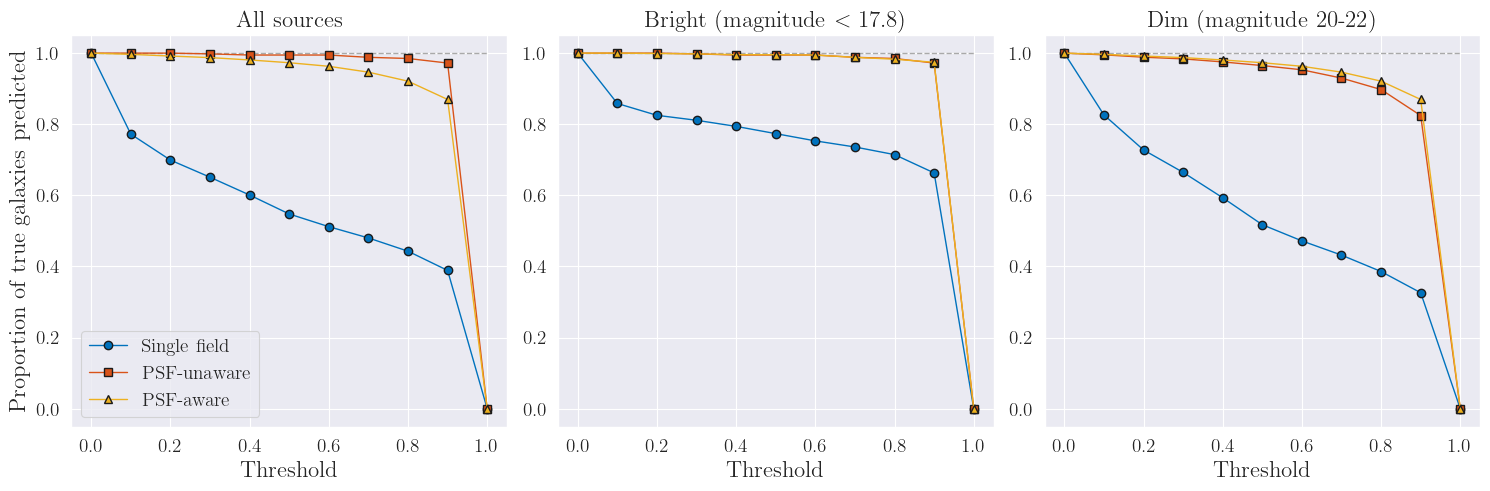

In [162]:
fig, ax = plt.subplots(1, 3, figsize=(5*3, 5))

# All
ax[0].hlines([1], 0, 1, color="darkgray", linewidth=1, linestyle="dashed")
ax[0].plot(thresholds, prop_all_gal["base"], c=COLORS[0], marker="o", markeredgecolor="k", markersize=6, linewidth=1, label="Single field")
ax[0].plot(thresholds, prop_bright_gal["unaware"], c=COLORS[1], marker="s", markeredgecolor="k", markersize=6, linewidth=1, label="PSF-unaware")
ax[0].plot(thresholds, prop_dim_gal["encode_params"], c=COLORS[2], marker="^", markeredgecolor="k", markersize=6, linewidth=1, label="PSF-aware")

ax[0].legend(fontsize="x-large")
ax[0].set_title("All sources", fontsize="xx-large")

# Bright
ax[1].hlines([1], 0, 1, color="darkgray", linewidth=1, linestyle="dashed")
ax[1].plot(thresholds, prop_bright_gal["base"], c=COLORS[0], marker="o", markeredgecolor="k", markersize=6, linewidth=1, label="Single field")
ax[1].plot(thresholds, prop_bright_gal["unaware"], c=COLORS[1], marker="s", markeredgecolor="k", markersize=6, linewidth=1, label="PSF-unaware")
ax[1].plot(thresholds, prop_bright_gal["encode_params"], c=COLORS[2], marker="^", markeredgecolor="k", markersize=6, linewidth=1, label="PSF-aware")

ax[1].set_title(f"Bright (magnitude $< 17.8$)", fontsize="xx-large")

# Dim
ax[2].hlines([1], 0, 1, color="darkgray", linewidth=1, linestyle="dashed")
ax[2].plot(thresholds, prop_dim_gal["base"], c=COLORS[0], marker="o", markeredgecolor="k", markersize=6, linewidth=1, label="Single field")
ax[2].plot(thresholds, prop_dim_gal["unaware"], c=COLORS[1], marker="s", markeredgecolor="k", markersize=6, linewidth=1, label="PSF-unaware")
ax[2].plot(thresholds, prop_dim_gal["encode_params"], c=COLORS[2], marker="^", markeredgecolor="k", markersize=6, linewidth=1, label="PSF-aware")

ax[2].set_title(f"Dim (magnitude 20-22)", fontsize="xx-large")

for a in ax:
    a.tick_params(axis="both", which="major", labelsize="x-large")
    a.set_xlabel("Threshold", fontsize="xx-large")
ax[0].set_ylabel("Proportion of true galaxies predicted", fontsize="xx-large")

fig.tight_layout()
plt.savefig("plots/calib/prop_gal_threshold_by_mag.pdf")

# line close to 1 suggests that probability of true galaxy being predicted to be galaxy is very high = good